### Name: Anvitha Chegu Ashokkumar
### Dragonfruit AI Assesment

# Solution for Software Engineering Challenge

## Questions

1. Efficient data structure that I used for the micro organism image was converting the image to its Run Length Encoding representation where the starting index and the count of consecutive 1s is used to store the binary image representation in a much more space efficient manner. Further, to fit the large image in memory while performing run length encoding, I broke down the image into 20 chunks using CHUNK_SIZE = 5000. Which breaks down the image into 20 chunks, each of shape - (5000, 100000), where the first chunk corresponds to first 5000 rows and so on. 
The same representation was used for storing dye image as well, because even though the image in this case is very sparse, RLE as it stores only 1s and not 0s, it would be able to handle the storage efficiently.
Both the data is stored in json files and can be read later.

2. For generating simulated images, I used Bezier curve which generates connected curves of arbitrary shapes. For the blob image, I generate a sufficiently large curve to fill more than 25% of the image. For the dye image, I generate multiple small curves. Finally, each curve is filled to convert into a polygon blob using skimage library. The blobs are generated of image size 1000 * 1000 initially and then scaled to required size of 100000 * 100000 using opencv library.

3. The function utilizes the rle encodings represenation of images which are broken down into chunks, calculates the percentages of area covered by the dye on the blob and aggregates the results across all chunks and prints the results based on the threshold of 10% whether micro organism has cancer or not.

4. The function I have written can be sped up by processing chunks in parallel using multiple threads and later once all the threads finish, aggregating the results to produce the final output. Given the time constraint, I am unable to handle the multi-thread processing for parallelizing the chunks processing for now. Decreasing the chunks size will lead to more chunks and can help in utilizing more threads, but it can also lead to a marginally increased storage requirements.

5. The runtime of my code from generating sample images of size 100000 * 100000 and detecing cancer is around 130 seconds. While, only the detection part consumes 70 seconds. Another compressing technique would be to combine both the images and then doing RLE for storing. This would significantly reduce the storage space.

6. Major tools used for the challenge of stackoverflow for looking at random image generation techniques and converting curves to polygons. ChatGPT was used for the above as well along with Perplexit.ai. LLM tools mentioned were also used for understanding Run Length Encoding and implementing the alogirthm.


In [1]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
import skimage.draw as draw
import cv2
from tqdm.notebook import tqdm
import json

### Utilities for generating random micro organism images and dye images of size 100000*100000

Here I use Bezier curve for generating the random images of micro organism blob and dye spread. Referred from [Stackoverflow](https://stackoverflow.com/questions/50731785/create-random-shape-contour-using-matplotlib)

In [3]:
bernstein = lambda n, k, t: binom(n,k)* t**k * (1.-t)**(n-k)

def bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for i in range(N):
        curve += np.outer(bernstein(N - 1, i, t), points[i])
    return curve

class Segment():
    def __init__(self, p1, p2, angle1, angle2, **kw):
        self.p1 = p1; self.p2 = p2
        self.angle1 = angle1; self.angle2 = angle2
        self.numpoints = kw.get("numpoints", 100)
        r = kw.get("r", 0.3)
        d = np.sqrt(np.sum((self.p2-self.p1)**2))
        self.r = r*d
        self.p = np.zeros((4,2))
        self.p[0,:] = self.p1[:]
        self.p[3,:] = self.p2[:]
        self.calc_intermediate_points(self.r)

    def calc_intermediate_points(self,r):
        self.p[1,:] = self.p1 + np.array([self.r*np.cos(self.angle1),
                                    self.r*np.sin(self.angle1)])
        self.p[2,:] = self.p2 + np.array([self.r*np.cos(self.angle2+np.pi),
                                    self.r*np.sin(self.angle2+np.pi)])
        self.curve = bezier(self.p,self.numpoints)


def get_curve(points, **kw):
    segments = []
    for i in range(len(points)-1):
        seg = Segment(points[i,:2], points[i+1,:2], points[i,2],points[i+1,2],**kw)
        segments.append(seg)
    curve = np.concatenate([s.curve for s in segments])
    return segments, curve

def ccw_sort(p):
    d = p-np.mean(p,axis=0)
    s = np.arctan2(d[:,0], d[:,1])
    return p[np.argsort(s),:]

def get_bezier_curve(a, rad=0.2, edgy=0):
    """ given an array of points *a*, create a curve through
    those points. 
    rad = is a number between 0 and 1 to steer the distance of
          control points.
    edgy = controls the smoothness of the curve, with edgy=0 being the smoothest.
    """
    p = np.arctan(edgy)/np.pi+.5
    a = ccw_sort(a)
    a = np.append(a, np.atleast_2d(a[0,:]), axis=0)
    d = np.diff(a, axis=0)
    ang = np.arctan2(d[:,1],d[:,0])
    f = lambda ang : (ang>=0)*ang + (ang<0)*(ang+2*np.pi)
    ang = f(ang)
    ang1 = ang
    ang2 = np.roll(ang,1)
    ang = p*ang1 + (1-p)*ang2 + (np.abs(ang2-ang1) > np.pi )*np.pi
    ang = np.append(ang, [ang[0]])
    a = np.append(a, np.atleast_2d(ang).T, axis=1)
    s, c = get_curve(a, r=rad, method="var")
    x,y = c.T
    return x,y, a


def get_random_points(n=5, scale=0.8, mindst=None, rec=0):
    """ create n random points in the unit square, which are *mindst*
    apart, then scale them."""
    mindst = mindst or .7/n
    a = np.random.rand(n,2)
    d = np.sqrt(np.sum(np.diff(ccw_sort(a), axis=0), axis=1)**2)
    if np.all(d >= mindst) or rec>=200:
        return a*scale
    else:
        return get_random_points(n=n, scale=scale, mindst=mindst, rec=rec+1)

### Method for generating random image with a blob of the micro organism body using Bezier curve.

In [4]:
def get_random_microorganism_image():
    """
    Returns an image with a randomly generated blob representing micro organism body.
    draw.polygon is used to form a filled polygon from the bezier curve recieved as 2d coordinates.

    The image is generated first is of size 1000*1000 which is then scaled up to 100000*100000 using cv2. This helps in efficiently generating testing samples.
    """
    rad = 0.2
    edgy = 0.05
    shape = (1000, 1000)
    image = np.zeros(shape, dtype=np.uint8)
    c = [0,0]
    a = get_random_points(n=7, scale=shape[0]) + c
    x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
    rr, cc = draw.polygon(x, y, shape=shape)
    image[rr, cc] = 1
    image = cv2.resize(image, dsize=(100000, 100000), interpolation=cv2.INTER_LINEAR)

    return image

### Method for generating random image with several small blobs representing dye spread using Bezier curve.

In [5]:
def get_dye_image(scale=100):
    """
    Returns an image with randomly generated blobs representing dye spread.
    The method randomly generates between 3 to 10 datapoints that serve as center for the blobs to be generated.
    draw.polygon is used to form a filled polygon from the bezier curve recieved as 2d coordinates.

    The image is generated first is of size 1000*1000 which is then scaled up to 100000*100000 using cv2. This helps in efficiently generating testing samples.

    scale = Scale parameter controls the size of the blob which will help for testing with different percentage of dye spread in the micro organism.
    """
    rad = 0.2
    edgy = 0.05
    shape = (1000, 1000)
    image = np.zeros((1000, 1000), dtype=np.uint8)
    num_elements = np.random.randint(3, 10)
    cs = np.random.rand(num_elements, 2) * 1000
    for c in cs:
        a = get_random_points(n=7, scale=scale) + c
        x,y, _ = get_bezier_curve(a,rad=rad, edgy=edgy)
        rr, cc = draw.polygon(x, y, shape=shape)
        image[rr, cc] = 1

    image = cv2.resize(image, dsize=(100000, 100000), interpolation=cv2.INTER_LINEAR)
    return image


### Method for encoding image using Run Length Encoding. 
Only consecutive 1s as count and starting index are stored. 0s are completely ommitted. Hence, this appraoch serves its purpose for sparse matrices as well as we are not storing 0s.

In [6]:
def encode_image_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


Decoding method converts a rle encoding to image given width and height of the final output.

In [7]:
def decode_rle_to_image(rle, height, width):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width))

    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1])] = 1

    return mask.reshape(height, width)

## Chunks used for processing

Because of resource constraints, and faster processing, we break down the images into chunks of CHUNK_SIZE * 100000. Hence, with chunk size of 5000, the image will be broken into 20 chunks of 5000 rows and 100000 columns. This will help us efficiently process them for checking cancer. While this increase the storage size by a small margin. It increases the speed of processing and significantly decreases the processing done on the whole image. It will also help in parallelization as separate chunks can be processed parallely.

In [8]:
CHUNK_SIZE = 5000

### Method for computing RLE encodings of the image chunk by chunk.
It returns an array of rle encodings of all the chunks sequentially in the image.

In [9]:
def get_chunk_rle_encodings(image):
    """
    Takes image of shape 100000*100000 and iterates over it chunk by chunk of size CHUNK_SIZE*100000 and encodes it using RLE.
    Output is a list of RLE encodings for each chunk.
    """
    rle_encodings = []
    for i in tqdm(range(0, 100000, CHUNK_SIZE)):
        rle_encodings.append(encode_image_to_rle(image[i:i+CHUNK_SIZE]))
    return rle_encodings

### Masking
Takes to corresponding chunks from blob image and dye image and applies the first chunk as mask for the second image. This ensures that any dye which is outside the blob is not considere.
Then it calculates the percentage of area in the chunk covered by the blob and percentage of area in the chunk covered by the newly masked dye and returns these 2 values.

Both the the chunks correspond to the same number of rows in the images.

In [10]:
def mask_chunk(image_mask_chunk, dye_mask_chunk):
    """
    Takes 2 images chunks of size CHUNK_SIZE*100000, first for blob image and second for 
    The chunks correspond to the same row indices in their respective images.

    First we apply blob chunk as mask on the dye chunk, which eliminate any dyes outside the blob region.
    Then we calcuate the percentage of area covered by blob in its chunk and dye in its masked chunk.

    outputs are the above 2 percentatges.
    """
    mask1, mask2 = image_mask_chunk, dye_mask_chunk
    masked_mask2 = np.where(mask1 == 1, mask2, 0)
    percentage_mask1 = np.count_nonzero(mask1 == 1) / mask1.size * 100
    percentage_mask2 = np.count_nonzero(masked_mask2 == 1) / masked_mask2.size * 100
    return percentage_mask1, percentage_mask2

## Detect Cancer
Utilizes RLE encodings of the 2 images and prints the percentage of area covered by micro organism in image and dye in micro organism and prints whether the micro organism has cancer or not.

In [11]:
def detect_cancer(rle_encodings_image, rle_encodings_dye):
    """
    Takes in 2 lists of rle encodings. One for blob image and second for dye image.
    We iterate over the lists together, taking encodings for the same row indices chunks for both the images and decode them.
    We decode the chunk encodings and use mask_chunk method to get the percentages of areas covered by blob in chunk and dye in chunk which is inside blob.
    After calculating percentages of all the chunks, we take the sum for both the images and normalize it by the number of chunks.
    First percentage gives us the percentage of area covered by blob in image.
    Second percentage divided by first one gives the percentage of area covered by dye in the blob.

    We print the results and check if second value is greater than 10 to determine whether micro organism has cancer or not.
    """
    percentages1 = []
    percentages2 = []
    for i, (rle_image, rle_dye) in enumerate(tqdm(zip(rle_encodings_image, rle_encodings_dye), total=len(rle_encodings_image))):
        if rle_image != '':
            image_mask_chunk = decode_rle_to_image(rle_image, CHUNK_SIZE, 100000)

            dye_mask_chunk = np.zeros((CHUNK_SIZE, 100000))
            if rle_dye != '':
                dye_mask_chunk = decode_rle_to_image(rle_dye, CHUNK_SIZE, 100000)

            percentage_mask1, percentage_mask2 = mask_chunk(image_mask_chunk, dye_mask_chunk)
            percentages1.append(percentage_mask1)
            percentages2.append(percentage_mask2)
        else:
            percentages1.append(0)
            percentages2.append(0)

        # decoded_image[start:end] = mask
    blob_percentage = sum(percentages1)/len(rle_encodings_image)
    dye_percentage = sum(percentages2)/len(rle_encodings_image)
    cancer_percentage = dye_percentage/blob_percentage*100

    print(f"Area in the image covered by blob: {blob_percentage}%")
    print(f"Area of the blob where dye has spread: {cancer_percentage}%")
    print(f"Does the micro organism has cancer: {cancer_percentage > 10}")

## Testing

All image display is done in the size of 10000 * 10000. But actual image sizes being worked on is 100000 * 100000

### Test case 1 - False case

Shape of blob image: (100000, 100000)
Shape of dye image: (100000, 100000)


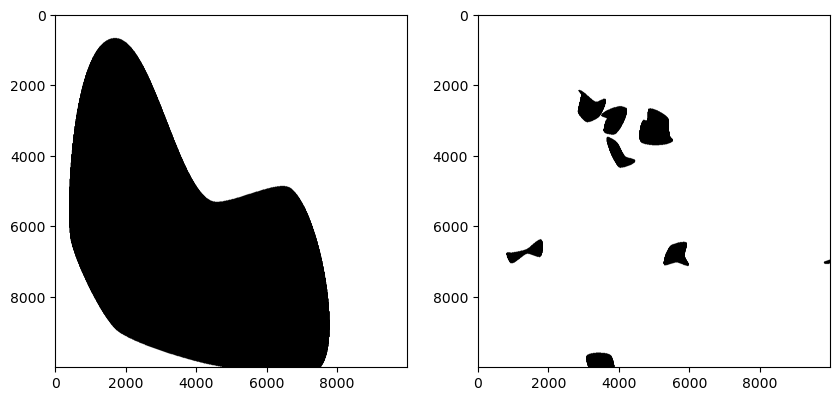

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
image_id = 1

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

image = get_random_microorganism_image()
axes[0].imshow(cv2.bitwise_not(cv2.resize(image, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

image_dye = get_dye_image()
axes[1].imshow(cv2.bitwise_not(cv2.resize(image_dye, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

print(f"Shape of blob image: {image.shape}")
print(f"Shape of dye image: {image_dye.shape}")
plt.show()

print()
rle_encodings_image = get_chunk_rle_encodings(image)
rle_encodings_dye = get_chunk_rle_encodings(image_dye)

data = {
    'blob': rle_encodings_image,
    'dye': rle_encodings_dye
}
json.dump(data, open(f'rle_image_{image_id}.json', 'w'))

In [13]:
data = json.load(open(f'rle_image_{image_id}.json'))
rle_encodings_image, rle_encodings_dye = data['blob'], data['dye']
detect_cancer(rle_encodings_image, rle_encodings_dye)

  0%|          | 0/20 [00:00<?, ?it/s]

Area in the image covered by blob: 41.54971701%
Area of the blob where dye has spread: 1.928845989028314%
Does the micro organism has cancer: False


### Test case 2 - True case

Shape of blob image: (100000, 100000)
Shape of dye image: (100000, 100000)


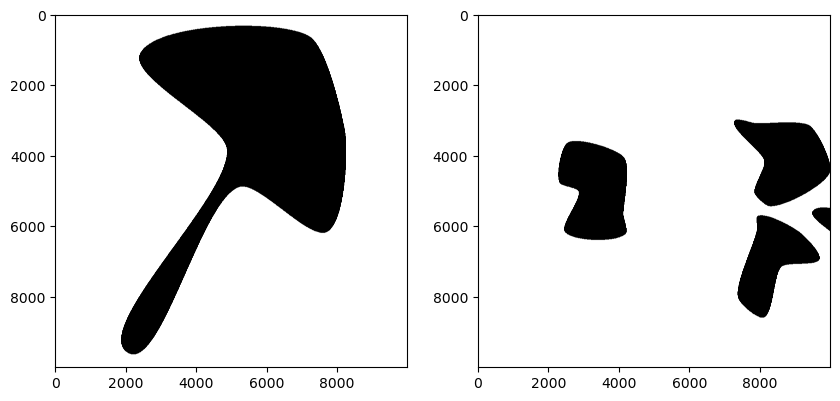

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
image_id = 2

fig, axes = plt.subplots(1, 2, figsize=(10, 20))

image = get_random_microorganism_image()
axes[0].imshow(cv2.bitwise_not(cv2.resize(image, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

# increasing scale to generate bigger dye spreads for positive cancer case
image_dye = get_dye_image(scale=300)
axes[1].imshow(cv2.bitwise_not(cv2.resize(image_dye, dsize=(10000, 10000), interpolation=cv2.INTER_LINEAR)), cmap='gray')

print(f"Shape of blob image: {image.shape}")
print(f"Shape of dye image: {image_dye.shape}")
plt.show()

print()
rle_encodings_image = get_chunk_rle_encodings(image)
rle_encodings_dye = get_chunk_rle_encodings(image_dye)

data = {
    'blob': rle_encodings_image,
    'dye': rle_encodings_dye
}
json.dump(data, open(f'rle_image_{image_id}.json', 'w'))

In [15]:
data = json.load(open(f'rle_image_{image_id}.json'))
rle_encodings_image, rle_encodings_dye = data['blob'], data['dye']
detect_cancer(rle_encodings_image, rle_encodings_dye)

  0%|          | 0/20 [00:00<?, ?it/s]

Area in the image covered by blob: 24.702449009999995%
Area of the blob where dye has spread: 4.956889211690353%
Does the micro organism has cancer: False
